In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.optimize import curve_fit
from scipy.integrate import quad
from scipy.stats import linregress

import os

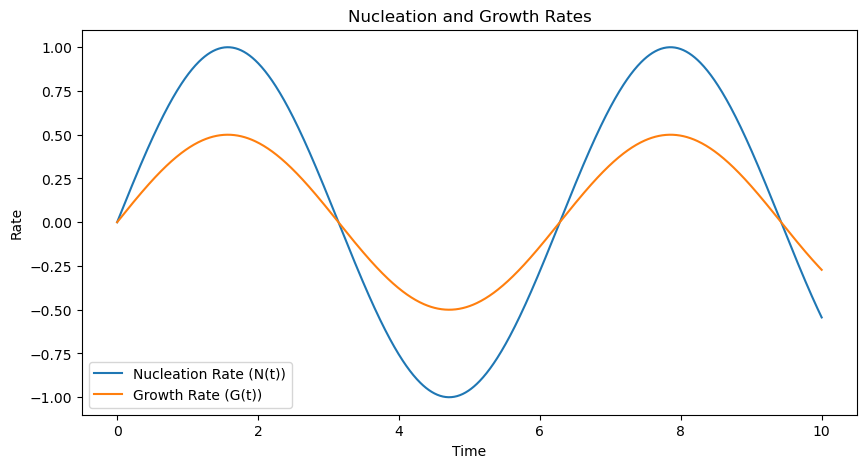

In [1]:

# Parameters
A = 1.0  # Amplitude of the nucleation rate
omega = 1.0  # Angular frequency
phi = 0.0  # Phase shift for nucleation rate
k = 0.5  # Proportionality constant for growth rate

# Time points
t = np.linspace(0, 10, 1000)

# Nucleation rate as a sine wave
N_t = A * np.sin(omega * t + phi)

# Growth rate calculation
G_t = k * N_t

# Plot results
plt.figure(figsize=(10, 5))
plt.plot(t, N_t, label='Nucleation Rate (N(t))')
plt.plot(t, G_t, label='Growth Rate (G(t))')
plt.xlabel('Time')
plt.ylabel('Rate')
plt.legend()
plt.title('Nucleation and Growth Rates')
plt.show()


### Pseudo-voigt, sigma and FVMH for a Williamson-Hall Plot

In [6]:


# Define the Pseudo-Voigt profile function
def pseudovoigt(x, center, amplitude, sigma, eta=0.7):
    gaussian = np.exp(-(x - center)**2 / (2 * sigma**2))
    lorentzian = 1 / (1 + ((x - center) / sigma)**2)
    return amplitude * (eta * lorentzian + (1 - eta) * gaussian)

# Calculate FWHM of the Pseudo-Voigt profile
def calculate_fwhm(sigma, eta):
    fwhm_gaussian = 2.35482 * sigma  # 2 * sqrt(2 * log(2))
    fwhm_lorentzian = 2 * sigma
    return eta * fwhm_lorentzian + (1 - eta) * fwhm_gaussian

# Fit the Pseudo-Voigt model and return parameters and FWHM
def fit_pseudovoigt(x, y, eta=0.7):
    try:
        initial_sigma = (x.max() - x.min()) / 4
        popt, pcov = curve_fit(lambda x, c, a, s: pseudovoigt(x, c, a, s, eta), x, y, p0=[x.mean(), y.max(), initial_sigma],maxfev=5000)
        sigma = popt[2]  # Optimized sigma
        fwhm = calculate_fwhm(sigma, eta)
        return popt, pcov, fwhm
    except Exception as e:
        print(f"Fit error: {e}")
        return [x.mean(), y.max(), initial_sigma, eta], None, calculate_fwhm(initial_sigma, eta)

def process_file(csv_path, output_csv_path, eta=0.7, q_min=2.0, q_max=2.1):
    df = pd.read_csv(csv_path)
    results = []

    grouped = df.groupby('frame_number')
    for frame, group in grouped:
        # Filter for q-value range
        group_filtered = group[(group['qvalue'] >= q_min) & (group['qvalue'] <= q_max)]
        
        if group_filtered.empty:
            print(f"No data in the specified q-value range for frame {frame}.")
            continue
        
        q_values = group_filtered['qvalue']
        intensities = group_filtered['intensity_izero_normalized']
        duration_s = group_filtered['duration_s'].iloc[0]  # Assuming duration is constant within a frame
        
        popt, _, fwhm = fit_pseudovoigt(q_values, intensities, eta)
        
        # Calculate area using regular integral
        def integral_function(x):
            return pseudovoigt(x, *popt)
        
        area, _ = quad(integral_function, q_min, q_max)
        
        results.append({
            'frame_number': frame,
            'duration_s': duration_s,
            'FWHM': fwhm,
            'sigma': popt[2],
            'pseudovoigt_area': area,
            'pseudovoigt_amplitude': popt[1]
        })
    
    results_df = pd.DataFrame(results)
    results_df.to_csv(output_csv_path, index=False)
    print(f"Results saved to {output_csv_path}")

# Setup files and process them
files = [
    'GDC-3D-NiO-therm-plasma-50mM-FPEI-_scan',
    'GEC-3D-NiO-ALD_plasma_50mM-FPEI-_00001',
    'GM-SnO2-3D-FPEI50mM-humid-beginning',
    'MF-NiOTherm-3D-PEI50mM-_SCAN',
]

fpath = '/Users/huriyeertay/Documents/IPVF/Analysis/'

# Process each directory
for fname in files:
    csv_path = os.path.join(fpath, fname, 'updated_frame_data.csv')
    output_csv_path = os.path.join(fpath, fname, 'results_100peak_frames.csv')
    if os.path.exists(csv_path):
        process_file(csv_path, output_csv_path, q_min=1.0, q_max=1.1)
    else:
        print(f"File {csv_path} does not exist.")

/Users/huriyeertay/miniconda3/envs/lillies/lib/python3.11/site-packages/scipy/optimize/_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


Results saved to /Users/huriyeertay/Documents/IPVF/Analysis/GDC-3D-NiO-therm-plasma-50mM-FPEI-_scan/results_100peak_frames.csv
Results saved to /Users/huriyeertay/Documents/IPVF/Analysis/GEC-3D-NiO-ALD_plasma_50mM-FPEI-_00001/results_100peak_frames.csv
Results saved to /Users/huriyeertay/Documents/IPVF/Analysis/GM-SnO2-3D-FPEI50mM-humid-beginning/results_100peak_frames.csv
Results saved to /Users/huriyeertay/Documents/IPVF/Analysis/MF-NiOTherm-3D-PEI50mM-_SCAN/results_100peak_frames.csv


In [5]:
def process_file(csv_path, output_csv_path, output_png_path, eta=0.7, frame_number=100, q_min=2.0, q_max=2.1):
    df = pd.read_csv(csv_path)
    
    # Filter for frame number 50 and q-value range
    group = df[(df['frame_number'] == frame_number) & (df['qvalue'] >= q_min) & (df['qvalue'] <= q_max)]
    
    if group.empty:
        print(f"Frame {frame_number} not found in the data or no data in the specified q-value range.")
        return
    
    q_values = group['qvalue']
    intensities = group['intensity_izero_normalized']
    
    popt, pcov, fwhm = fit_pseudovoigt(q_values, intensities, eta)
    fitted_intensities = pseudovoigt(q_values, *popt)
    
    # Calculate residuals
    residuals = intensities - fitted_intensities
    
    # Create the plot
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8), sharex=True, gridspec_kw={'height_ratios': [1, 3]})
    
    # Plot residuals
    ax1.scatter(q_values, residuals, color='blue', s=5, label='residuals')
    ax1.axhline(y=0, color='black', linestyle='-', linewidth=0.5)
    ax1.set_ylabel('residuals')
    ax1.legend()
    ax1.set_title('Model(pvoigt)')
    
    # Plot data and fit
    ax2.scatter(q_values, intensities, color='red', s=5, label='data')
    ax2.plot(q_values, fitted_intensities, 'g-', label='best-fit')
    ax2.set_xlabel('qvalue')
    ax2.set_ylabel('intensity_izero_normalized')
    ax2.legend()
    
    # Set x-axis limits
    ax1.set_xlim(q_min, q_max)
    ax2.set_xlim(q_min, q_max)
    
    plt.tight_layout()
    plt.savefig(output_png_path)
    plt.close()
    
    # Save results
    results = {
        'frame_number': frame_number,
        'center': popt[0],
        'amplitude': popt[1],
        'sigma': popt[2],
        'FWHM': fwhm,
    }
    
    pd.DataFrame([results]).to_csv(output_csv_path, index=False)
    print(f"Results and plot for frame {frame_number} saved.")

# Usage
for fname in files:
    csv_path = os.path.join(fpath, fname, 'updated_frame_data.csv')
    #output_csv_path = os.path.join(fpath, fname, 'results_frame_150_q_1_to_1.1.csv')
    output_png_path = os.path.join(fpath, fname, 'plot_frame_100_q_2_to_2.1.png')
    if os.path.exists(csv_path):
        process_file(csv_path, output_csv_path, output_png_path, frame_number=100, q_min=1.0, q_max=1.1)
    else:
        print(f"File {csv_path} does not exist.")

Results and plot for frame 100 saved.
Results and plot for frame 100 saved.
Frame 100 not found in the data or no data in the specified q-value range.
Frame 100 not found in the data or no data in the specified q-value range.


### Creating FWHM and Area Plots

In [8]:
 

def plot_data(df, x_col, y_col, output_path, title, xlabel, ylabel):
    """Function to generate and save plots."""
    plt.figure(figsize=(10, 6))
    plt.scatter(df[x_col], df[y_col], color='blue', marker='o')
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.grid(True)
    plt.savefig(output_path)
    plt.close()
    print(f"Plot saved to {output_path}")  # Confirm plot saving

def process_results(base_path, fname, crystallisation_path):
    """Read results, generate and save plots for each dataset."""
    results_path = os.path.join(base_path, fname, 'results.csv')
    if not os.path.exists(results_path):
        print(f"Results file not found: {results_path}")
        return
    
    # Read results.csv
    df = pd.read_csv(results_path)

    # Ensure correct column names are used and exist in the dataframe
    if 'duration_s' not in df or 'FWHM' not in df or 'area' not in df:
        print(f"Required columns are missing in {results_path}")
        return

    # Plot FWHM vs. duration
    fwhm_plot_path = os.path.join(crystallisation_path, f'FWHM_{fname}.png')
    plot_data(df, 'duration_s', 'FWHM', fwhm_plot_path, 'FWHM vs. Duration', 'Duration (s)', 'FWHM')

    # Plot area vs. duration
    area_plot_path = os.path.join(crystallisation_path, f'area_{fname}.png')
    plot_data(df, 'duration_s', 'area', area_plot_path, 'Area vs. Duration', 'Duration (s)', 'Area')

# Main execution block
files = [
    'GDC-3D-NiO-therm-plasma-50mM-FPEI-_scan',
    'GEC-3D-NiO-ALD_plasma_50mM-FPEI-_00001',
    'GM-SnO2-3D-FPEI50mM-humid-beginning',
    'MF-NiOTherm-3D-PEI50mM-_SCAN',
]
base_path = '/Users/huriyeertay/Documents/IPVF/Analysis/'
crystallisation_path = os.path.join(base_path, 'crystallisation/')

# Ensure the crystallisation directory exists
if not os.path.exists(crystallisation_path):
    os.makedirs(crystallisation_path)

# Process each file
for fname in files:
    process_results(base_path, fname, crystallisation_path)


Plot saved to /Users/huriyeertay/Documents/IPVF/Analysis/crystallisation/FWHM_GDC-3D-NiO-therm-plasma-50mM-FPEI-_scan.png
Plot saved to /Users/huriyeertay/Documents/IPVF/Analysis/crystallisation/area_GDC-3D-NiO-therm-plasma-50mM-FPEI-_scan.png
Plot saved to /Users/huriyeertay/Documents/IPVF/Analysis/crystallisation/FWHM_GEC-3D-NiO-ALD_plasma_50mM-FPEI-_00001.png
Plot saved to /Users/huriyeertay/Documents/IPVF/Analysis/crystallisation/area_GEC-3D-NiO-ALD_plasma_50mM-FPEI-_00001.png
Plot saved to /Users/huriyeertay/Documents/IPVF/Analysis/crystallisation/FWHM_GM-SnO2-3D-FPEI50mM-humid-beginning.png
Plot saved to /Users/huriyeertay/Documents/IPVF/Analysis/crystallisation/area_GM-SnO2-3D-FPEI50mM-humid-beginning.png
Plot saved to /Users/huriyeertay/Documents/IPVF/Analysis/crystallisation/FWHM_MF-NiOTherm-3D-PEI50mM-_SCAN.png
Plot saved to /Users/huriyeertay/Documents/IPVF/Analysis/crystallisation/area_MF-NiOTherm-3D-PEI50mM-_SCAN.png


### Creating Williamson Hall Plots

In [16]:


def calculate_williamson_hall_params(df, lambda_xray):
    """Calculate parameters for Williamson-Hall plot."""
    df['theta'] = np.radians(df['center'] / 2)  # Convert center to Bragg angle in radians
    df['beta_cos_theta'] = df['FWHM'] * np.cos(df['theta'])
    df['four_sin_theta'] = 4 * np.sin(df['theta'])
    return df

def plot_williamson_hall(df, output_path):
    """Plot and save the Williamson-Hall plot."""
    plt.figure(figsize=(10, 6))
    plt.scatter(df['four_sin_theta'], df['beta_cos_theta'], color='blue', marker='o')
    plt.title('Williamson-Hall Plot')
    plt.xlabel('4*sin(θ) [strain term]')
    plt.ylabel('β*cos(θ) [size term]')
    plt.grid(True)
    plt.savefig(output_path)
    plt.close()
    print(f"Williamson-Hall plot saved to {output_path}")

# Main execution block
files = [
    'GDC-3D-NiO-therm-plasma-50mM-FPEI-_scan',
    'GEC-3D-NiO-ALD_plasma_50mM-FPEI-_00001',
    'GM-SnO2-3D-FPEI50mM-humid-beginning',
    'MF-NiOTherm-3D-PEI50mM-_SCAN',
]
base_path = '/Users/huriyeertay/Documents/IPVF/Analysis/'
crystallisation_path = os.path.join(base_path, 'crystallisation/')
lambda_xray = 1.5406  # X-ray wavelength in Ångstroms, adjust as necessary

# Ensure the crystallisation directory exists
if not os.path.exists(crystallisation_path):
    os.makedirs(crystallisation_path)

# Process each file
for fname in files:
    results_path = os.path.join(base_path, fname, 'results.csv')
    if os.path.exists(results_path):
        df = pd.read_csv(results_path)
        df = calculate_williamson_hall_params(df, lambda_xray)
        wh_plot_path = os.path.join(crystallisation_path, f'Williamson-Hall_{fname}.png')
        plot_williamson_hall(df, wh_plot_path)
    else:
        print(f"Results file not found: {results_path}")


Williamson-Hall plot saved to /Users/huriyeertay/Documents/IPVF/Analysis/crystallisation/Williamson-Hall_GDC-3D-NiO-therm-plasma-50mM-FPEI-_scan.png
Williamson-Hall plot saved to /Users/huriyeertay/Documents/IPVF/Analysis/crystallisation/Williamson-Hall_GEC-3D-NiO-ALD_plasma_50mM-FPEI-_00001.png
Williamson-Hall plot saved to /Users/huriyeertay/Documents/IPVF/Analysis/crystallisation/Williamson-Hall_GM-SnO2-3D-FPEI50mM-humid-beginning.png
Williamson-Hall plot saved to /Users/huriyeertay/Documents/IPVF/Analysis/crystallisation/Williamson-Hall_MF-NiOTherm-3D-PEI50mM-_SCAN.png


### Calculating Micro-Strain

In [17]:


def calculate_williamson_hall_params(df, lambda_xray):
    """Calculate parameters for Williamson-Hall plot."""
    df['theta'] = np.radians(df['center'] / 2)  # Convert center to Bragg angle in radians
    df['beta_cos_theta'] = df['FWHM'] * np.cos(df['theta'])
    df['four_sin_theta'] = 4 * np.sin(df['theta'])
    return df

def plot_williamson_hall(df, output_path):
    """Plot and save the Williamson-Hall plot."""
    plt.figure(figsize=(10, 6))
    plt.scatter(df['four_sin_theta'], df['beta_cos_theta'], color='blue', marker='o')
    plt.title('Williamson-Hall Plot')
    plt.xlabel('4*sin(θ) [strain term]')
    plt.ylabel('β*cos(θ) [size term]')
    plt.grid(True)
    plt.savefig(output_path)
    plt.close()
    print(f"Williamson-Hall plot saved to {output_path}")

def calculate_microstrain(df):
    """Calculate the microstrain from the Williamson-Hall plot data."""
    slope, intercept, r_value, p_value, std_err = linregress(df['four_sin_theta'], df['beta_cos_theta'])
    return slope  # Microstrain is the slope of the line

# Main execution block
files = [
    'GDC-3D-NiO-therm-plasma-50mM-FPEI-_scan',
    'GEC-3D-NiO-ALD_plasma_50mM-FPEI-_00001',
    'GM-SnO2-3D-FPEI50mM-humid-beginning',
    'MF-NiOTherm-3D-PEI50mM-_SCAN',
]
base_path = '/Users/huriyeertay/Documents/IPVF/Analysis/'
crystallisation_path = os.path.join(base_path, 'crystallisation/')
lambda_xray = 1.5406  # X-ray wavelength in Ångstroms

# Ensure the crystallisation directory exists
if not os.path.exists(crystallisation_path):
    os.makedirs(crystallisation_path)

# Process each file
for fname in files:
    results_path = os.path.join(base_path, fname, 'results.csv')
    if os.path.exists(results_path):
        df = pd.read_csv(results_path)
        df = calculate_williamson_hall_params(df, lambda_xray)
        wh_plot_path = os.path.join(crystallisation_path, f'Williamson-Hall_{fname}.png')
        plot_williamson_hall(df, wh_plot_path)
        microstrain = calculate_microstrain(df)
        print(f"Microstrain for {fname}: {microstrain}")
    else:
        print(f"Results file not found: {results_path}")


Williamson-Hall plot saved to /Users/huriyeertay/Documents/IPVF/Analysis/crystallisation/Williamson-Hall_GDC-3D-NiO-therm-plasma-50mM-FPEI-_scan.png
Microstrain for GDC-3D-NiO-therm-plasma-50mM-FPEI-_scan: -7.844291482441273
Williamson-Hall plot saved to /Users/huriyeertay/Documents/IPVF/Analysis/crystallisation/Williamson-Hall_GEC-3D-NiO-ALD_plasma_50mM-FPEI-_00001.png
Microstrain for GEC-3D-NiO-ALD_plasma_50mM-FPEI-_00001: -29.00464857985045
Williamson-Hall plot saved to /Users/huriyeertay/Documents/IPVF/Analysis/crystallisation/Williamson-Hall_GM-SnO2-3D-FPEI50mM-humid-beginning.png
Microstrain for GM-SnO2-3D-FPEI50mM-humid-beginning: -5.941715690585697
Williamson-Hall plot saved to /Users/huriyeertay/Documents/IPVF/Analysis/crystallisation/Williamson-Hall_MF-NiOTherm-3D-PEI50mM-_SCAN.png
Microstrain for MF-NiOTherm-3D-PEI50mM-_SCAN: 6.17609528716034
